# Validation and Test Splits

In most of the examples and homeworks so far we've used cross validation with three splits:
* **Train:** The data we train candidate models on
* **Validation:** The data we use to choose the best model
* **Test:** The data we use to evaluate our final model

The splitting strategy should be related to the actual engineering challenge (if you want a model that can interpolate among data, randomly sample; if you want a model that can extrapolate to the future, split on time, etc).

If you are pretty sure of the model and hyperparameters (model settings) that you will use and the dataset is very small, it's sometimes ok to just use a train/test split. It is pretty common in research literature to see models with just train/test splits. 

However, you should be extremely careful when doing this. To demonstrate the dangers let's consider a toy problem!

## Toy problem: random number features and target

We're going to use a very simple dataset - 20 random numbers chosen by randomly sampling from a Gaussian/normal distribution. No matter how savvy I am, I shouldn't be able to make a machine learning model that predicts the random features (unless I make a model that uses the same random number generator).

In [1]:
import numpy as np

# Generate N random data points with M random features
N = 20
M = 10000

np.random.seed(42)
X = np.random.normal(size=(N, M))
y = np.random.normal(size=(N,))

print(y)

[ 1.56184071 -0.09422831 -1.3295356  -1.38863813 -0.34265078 -1.58051977
  0.58714807  0.1981725   0.0495192  -0.6193627  -0.94489762 -0.93269474
  0.17683628  0.20371839 -0.35018613 -1.36215693  0.74746454 -0.49795902
  0.12520995  0.38238882]


Now, let's split this dataset into a 60/20/20 train/val/test split.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, train_size=0.5)

I'm going to propose a very simple model with 4 parameters. I will take 

In [4]:
from sklearn.linear_model import LinearRegression


class SimpleModel:
    def __init__(self, column=1):
        self.column = column
        return

    def fit(self, X, y):
        self.LR = LinearRegression()
        self.LR.fit(X[:, self.column : self.column + 1], y)
        return

    def predict(self, X):
        return self.LR.predict(X[:, self.column : self.column + 1])
    

Now, let's fit this model and score it on the validation set.

In [5]:
from sklearn.metrics import mean_absolute_error

SM = SimpleModel()
SM.fit(X_train, y_train)

MAE = mean_absolute_error(SM.predict(X_val), y_val)
print(f"The model MAE is {MAE:0.2f}")

The model MAE is 0.70


So far so good! Now, let's find the column that minimizes the validation error by doing some simple feature selection.

In [6]:
best_column = -1
best_MAE = 10

for column in range(M):
    SM = SimpleModel(column=column)
    SM.fit(X_train, y_train)
    MAE = mean_absolute_error(SM.predict(X_val), y_val)

    if MAE < best_MAE:
        best_column = column
        best_MAE = MAE

In [7]:
print(f"The best column is {best_column} with a validation MAE of {best_MAE:0.2f}")

The best column is 1246 with a validation MAE of 0.21


Awesome! We found a model with a validation error of 0.21 eV! This is exciting. Finally, let's check our test error. 

In [8]:
MAE = mean_absolute_error(SM.predict(X_test), y_test)
print(f"The model MAE is {MAE:0.2f}")

The model MAE is 1.15


This is VERY different; what happened here? Which of these numbers do you trust more? 

Let's visualize what happened here!

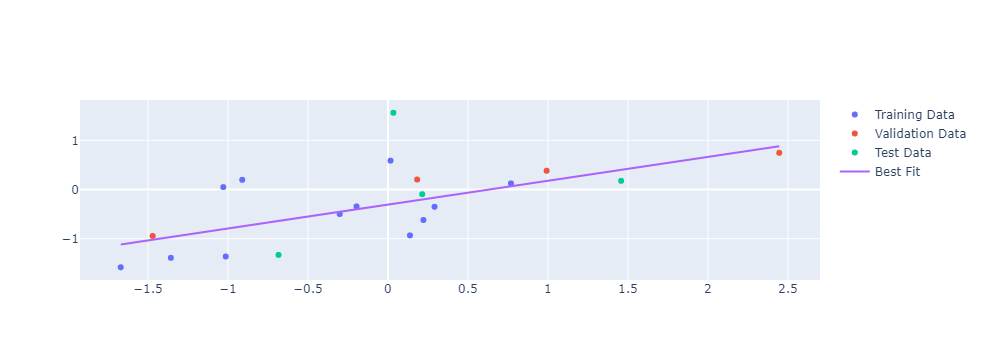

In [9]:
import plotly.graph_objects as go

# Plot with plotly!
fig = go.Figure()
fig.add_scatter(
    x=X_train[:, best_column : best_column + 1].reshape((-1,)),
    y=y_train,
    mode="markers",
    name="Training Data",
)
fig.add_scatter(
    x=X_val[:, best_column : best_column + 1].reshape((-1,)),
    y=y_val,
    mode="markers",
    name="Validation Data",
)
fig.add_scatter(
    x=X_test[:, best_column : best_column + 1].reshape((-1,)),
    y=y_test,
    mode="markers",
    name="Test Data",
)

# Fit the best model we found and plot it
SM = SimpleModel(column=best_column)
SM.fit(X_train, y_train)

fig.add_scatter(
    x=X[:, best_column : best_column + 1].reshape((-1,)),
    y=SM.predict(X),
    name="Best Fit",
)